### To make LDA plot in figure 5
* use R version 4.2.1 and rpy2 version 3.5.9

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import colors
import os
from numpy import ma
import seaborn as sns
%matplotlib inline
import ipywidgets
from operator import itemgetter

In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure4 data_SenstiveResistant')

In [3]:
# import data from github

dfSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/Protein_pVals_Final_WithMetaData.xlsx', sheet_name='Sheet1')

In [4]:
# Filter for the analysis
df = dfSarcoma

df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("dataType == 'NormalizedIntensity_Log2'")

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column specifying the dataset
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfProtein = df

,sample,dataset,race,cancer,sensitivity,gender,group,dataType,cancerType,age,timing,patient,protAcc,area
11,BJW.S.Pre,sarcoma,WHITE,c,S,M,S.Pre,NormalizedIntensity_Log2,EPI,30-39,Pre,BJW,A0A075B6H7,1.639
20,BNN.S.Post,sarcoma,WHITE,c,S,F,S.Post,NormalizedIntensity_Log2,MPNST,70-79,Post,BNN,A0A075B6H7,-1.775
22,BNV.R.Post,sarcoma,WHITE,c,R,M,R.Post,NormalizedIntensity_Log2,PS/MFH,50-59,Post,BNV,A0A075B6H7,0.777
25,BPA.R.Pre,sarcoma,WHITE,c,R,M,R.Pre,NormalizedIntensity_Log2,LS,50-59,Pre,BPA,A0A075B6H7,0.646
26,BPE.S.Post,sarcoma,WHITE,c,S,M,S.Post,NormalizedIntensity_Log2,LS,60-69,Post,BPE,A0A075B6H7,-0.856


#### annotate merged long/tidy data with uniprot IDs (or other metadata)

In [5]:
# make dfUniprot for annotation, this excel file is on the associated GitHub page

dfUniprot = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/uniprot-download_true_fields_accession_2Creviewed_2Cid_2Cprotein_nam-2023.03.17-19.33.16.44.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,protAcc,Reviewed,Protein names,geneNamePrimary
0,A0A075B6G3,unreviewed,Dystrophin,DMD
1,A0A087WV00,unreviewed,Diacylglycerol kinase (DAG kinase) (EC 2.7.1.107),DGKI
2,A0A087WZT3,unreviewed,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6
3,A0A087X1C5,reviewed,Putative cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7
4,A0A0A0MQU7,unreviewed,HNF1 homeobox A,HNF1A
...,...,...,...,...
81786,X6RLU5,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81787,X6RLV5,unreviewed,DEAD-box helicase 5,DDX5
81788,X6RLY7,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81789,X6RM00,unreviewed,ELKS/RAB6-interacting/CAST family member 1,ERC1


In [6]:
# annotate uniprot info

dfMerged = dfProtein.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfMerged.columns
numCols = dfMerged._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfMerged['area'] = dfMerged['area'].astype(float)

In [7]:
# remove Remove 'crapome' proteins

crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']

dfMerged = dfMerged.loc[~dfMerged['geneNamePrimary'].str.contains('|'.join(crapome))]

In [8]:
# count protein IDs

dfTemp = dfMerged

#drop 0 values
dfTemp['area'].replace(0, np.nan, inplace=True)
dfTemp.dropna(subset = ['area'], inplace = True)

# count
dfTemp['nSamples'] = dfTemp.groupby('protAcc')['protAcc'].transform('count')

# filter by N detections
dfTemp = dfTemp.query('nSamples > 80')

dfFiltered = dfTemp

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_62791/3885344176.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfTemp['area'].replace(0, np.nan, inplace=True)


In [9]:
# find and select data/feature columns

dfTemp = dfFiltered.query('timing == "Pre" | timing == "Control"')
totalCols = dfTemp.columns
numCols = dfTemp._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

# pivot 
dfLDAPre = dfTemp.pivot_table(
    values = 'area',
    index = ['group', 'sample'],
    columns = ['geneNamePrimary'],
).reset_index().rename_axis(None, axis=1)

dfLDAPre.drop(columns = ['sample'], inplace = True)

# impute nan to min value in column
for col in dfLDAPre.columns:
    dfLDAPre[col].fillna(value = dfLDAPre[col].min(), inplace = True)

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_62791/2841122679.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfLDAPre[col].fillna(value = dfLDAPre[col].min(), inplace = True)


In [10]:
# remove highly correlated/co-linear features

dfTemp = dfLDAPre

corr_matrix = dfTemp.corr(method = 'spearman', numeric_only = True).abs()

# make upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation greater than 0.67
to_drop = [column for column in upper.columns if any(upper[column] > 0.67)]

# drop highly correlated features
dfTemp.drop(to_drop, axis=1, inplace=True)

dfLDAPre = dfTemp

In [11]:
# delete any redundant columns

nunique = dfLDAPre.nunique()
cols_to_drop = nunique[nunique == 1].index
dfLDAPre.drop(cols_to_drop, axis=1, inplace = True)

### LDA using MASS from R

In [12]:
import rpy2
import rpy2.ipython
import rpy2.ipython.html
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.ipython.html
import rpy2.robjects.packages as rpackages
rpy2.ipython.html.init_printing()

packnames = ('ggplot2', 'MASS', 'tidyverse') #('ggplot2', 'MASS', 'proteoQ','tidyverse','caret')

base = importr('base') # import R's "base" package
utils = importr('utils') # import R's "utils" package

# select a mirror for R packages
utils.chooseCRANmirror(ind=1)

# load the R magic extension
%load_ext rpy2.ipython 

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be installed.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [13]:
# load the packages

MASS = importr('MASS')
tidyverse = importr('tidyverse')

In [14]:
# Encodes the dfLDAPre into R

%R -i dfLDAPre

In [15]:
%%R

model <- lda(
    group ~ .,
    data = dfLDAPre,
    tol = 0.000000000001,
    method = 'moment',
)

predictions <- predict(model)

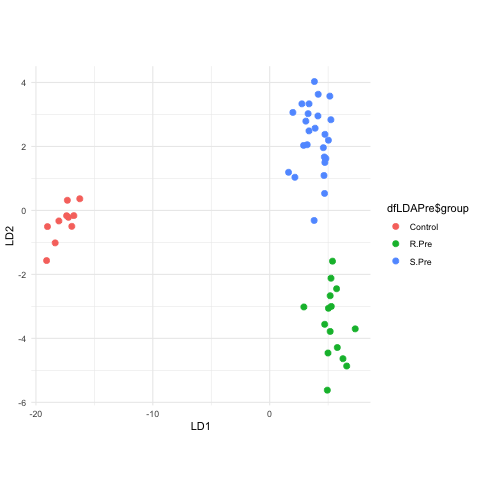

In [16]:
%%R
# plot LDA

newdata <- data.frame(type = dfLDAPre[,1], lda = predictions$x) # make a df for ggplot
ggplot(newdata) + geom_point(aes(lda.LD1, lda.LD2, colour = dfLDAPre$group), size = 2.5)+
  guides(fill = "none") + 
  labs(title = "", x = "LD1", y = "LD2") +
  theme_minimal() +
  theme(aspect.ratio = 1)

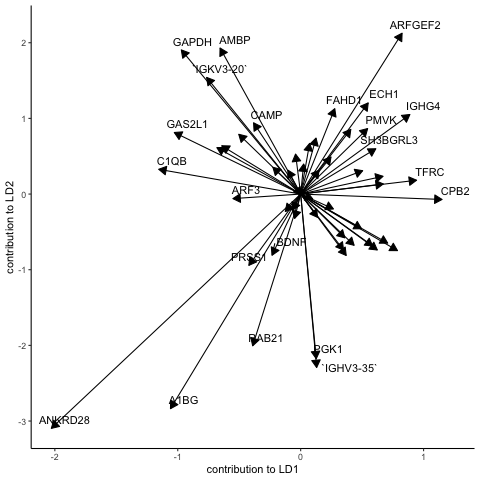

In [17]:
%%R

#plot scalings
library(ggrepel)

ldaScaling <-data.frame(model$scaling) # make a df for ggplot
ldaScaling$Proteins <- row.names(ldaScaling)

ggplot() + 
  geom_segment(data = ldaScaling, aes(x=0, xend=LD1, y=0, yend=LD2),
               arrow = arrow(length = unit(0.3, "cm"),type='closed'),
               colour="black") +
  labs(x = "contribution to LD1", y = "contribution to LD2") +

geom_text_repel(data = ldaScaling,
                  force = 1,
                  force_pull = 0,
                  max.overlaps = 3,
                  nudge_x = .1,
                  nudge_y = .1,
                  aes(x = LD1, y = LD2, label = rownames(ldaScaling))
                 )+
  theme_classic()